Architectures for Neuro-Cryptanalysis

COS485 Project Code

12 May 2020

Benjamin Kuykendall, Alberto Mizrahi, Abhishek Kumar Singh


# Imports

In [ ]:
!pip install bitstring

     |████████████████████████████████| 204kB 3.5MB/s 
  Created wheel for bitstring: filename=bitstring-3.1.7-cp36-none-any.whl size=37948 sha256=013985f8e46ce1bc61abe265a025f3abb32766c10d95baf61a59a14c0e5f7daf
  Stored in directory: /root/.cache/pip/wheels/b8/27/f0/8373e26b7de57db03dc18aaaebdd8c26a99da882416f762979
Successfully built bitstring


In [ ]:
from IPython import display

from bitstring import Bits, BitArray
from io import BytesIO
import math
import matplotlib.pyplot as plt
import numpy as np
from os import path, mkdir
import secrets
import struct
import time

import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F 
import torch.optim as optim

# DES Encryption

## Binary implementation

Quite fast. Good for data generation.

Custom fork of [pip DES library](https://github.com/0x10001/des).

In [ ]:
try:
    number_type = int, long
except NameError:
    number_type = int

try:
    iter_range = xrange
except NameError:
    iter_range = range


INITIAL_PERMUTATION = (
    57, 49, 41, 33, 25, 17, 9,  1,
    59, 51, 43, 35, 27, 19, 11, 3,
    61, 53, 45, 37, 29, 21, 13, 5,
    63, 55, 47, 39, 31, 23, 15, 7,
    56, 48, 40, 32, 24, 16, 8,  0,
    58, 50, 42, 34, 26, 18, 10, 2,
    60, 52, 44, 36, 28, 20, 12, 4,
    62, 54, 46, 38, 30, 22, 14, 6,
)

INVERSE_PERMUTATION = (
    39, 7,  47, 15, 55, 23, 63, 31,
    38, 6,  46, 14, 54, 22, 62, 30,
    37, 5,  45, 13, 53, 21, 61, 29,
    36, 4,  44, 12, 52, 20, 60, 28,
    35, 3,  43, 11, 51, 19, 59, 27,
    34, 2,  42, 10, 50, 18, 58, 26,
    33, 1,  41, 9,  49, 17, 57, 25,
    32, 0,  40, 8,  48, 16, 56, 24,
)

EXPANSION = (
    31, 0,  1,  2,  3,  4,
    3,  4,  5,  6,  7,  8,
    7,  8,  9,  10, 11, 12,
    11, 12, 13, 14, 15, 16,
    15, 16, 17, 18, 19, 20,
    19, 20, 21, 22, 23, 24,
    23, 24, 25, 26, 27, 28,
    27, 28, 29, 30, 31, 0,
)

PERMUTATION = (
    15, 6,  19, 20, 28, 11, 27, 16,
    0,  14, 22, 25, 4,  17, 30, 9,
    1,  7,  23, 13, 31, 26, 2,  8,
    18, 12, 29, 5,  21, 10, 3,  24,
)

PERMUTED_CHOICE1 = (
    56, 48, 40, 32, 24, 16, 8,
    0,  57, 49, 41, 33, 25, 17,
    9,  1,  58, 50, 42, 34, 26,
    18, 10, 2,  59, 51, 43, 35,
    62, 54, 46, 38, 30, 22, 14,
    6,  61, 53, 45, 37, 29, 21,
    13, 5,  60, 52, 44, 36, 28,
    20, 12, 4,  27, 19, 11, 3,
)

PERMUTED_CHOICE2 = (
    13, 16, 10, 23, 0,  4,
    2,  27, 14, 5,  20, 9,
    22, 18, 11, 3,  25, 7,
    15, 6,  26, 19, 12, 1,
    40, 51, 30, 36, 46, 54,
    29, 39, 50, 44, 32, 47,
    43, 48, 38, 55, 33, 52,
    45, 41, 49, 35, 28, 31,
)

SUBSTITUTION_BOX = (
    (
        14, 4,  13, 1,  2,  15, 11, 8,  3,  10, 6,  12, 5,  9,  0,  7,
        0,  15, 7,  4,  14, 2,  13, 1,  10, 6,  12, 11, 9,  5,  3,  8,
        4,  1,  14, 8,  13, 6,  2,  11, 15, 12, 9,  7,  3,  10, 5,  0,
        15, 12, 8,  2,  4,  9,  1,  7,  5,  11, 3,  14, 10, 0,  6,  13,
    ),
    (
        15, 1,  8,  14, 6,  11, 3,  4,  9,  7,  2,  13, 12, 0,  5,  10,
        3,  13, 4,  7,  15, 2,  8,  14, 12, 0,  1,  10, 6,  9,  11, 5,
        0,  14, 7,  11, 10, 4,  13, 1,  5,  8,  12, 6,  9,  3,  2,  15,
        13, 8,  10, 1,  3,  15, 4,  2,  11, 6,  7,  12, 0,  5,  14, 9,
    ),
    (
        10, 0,  9,  14, 6,  3,  15, 5,  1,  13, 12, 7,  11, 4,  2,  8,
        13, 7,  0,  9,  3,  4,  6,  10, 2,  8,  5,  14, 12, 11, 15, 1,
        13, 6,  4,  9,  8,  15, 3,  0,  11, 1,  2,  12, 5,  10, 14, 7,
        1,  10, 13, 0,  6,  9,  8,  7,  4,  15, 14, 3,  11, 5,  2,  12,
    ),
    (
        7,  13, 14, 3,  0,  6,  9,  10, 1,  2,  8,  5,  11, 12, 4,  15,
        13, 8,  11, 5,  6,  15, 0,  3,  4,  7,  2,  12, 1,  10, 14, 9,
        10, 6,  9,  0,  12, 11, 7,  13, 15, 1,  3,  14, 5,  2,  8,  4,
        3,  15, 0,  6,  10, 1,  13, 8,  9,  4,  5,  11, 12, 7,  2,  14,
    ),
    (
        2,  12, 4,  1,  7,  10, 11, 6,  8,  5,  3,  15, 13, 0,  14, 9,
        14, 11, 2,  12, 4,  7,  13, 1,  5,  0,  15, 10, 3,  9,  8,  6,
        4,  2,  1,  11, 10, 13, 7,  8,  15, 9,  12, 5,  6,  3,  0,  14,
        11, 8,  12, 7,  1,  14, 2,  13, 6,  15, 0,  9,  10, 4,  5,  3,
    ),
    (
        12, 1,  10, 15, 9,  2,  6,  8,  0,  13, 3,  4,  14, 7,  5,  11,
        10, 15, 4,  2,  7,  12, 9,  5,  6,  1,  13, 14, 0,  11, 3,  8,
        9,  14, 15, 5,  2,  8,  12, 3,  7,  0,  4,  10, 1,  13, 11, 6,
        4,  3,  2,  12, 9,  5,  15, 10, 11, 14, 1,  7,  6,  0,  8,  13,
    ),
    (
        4,  11,  2, 14, 15, 0,  8,  13, 3,  12, 9,  7,  5,  10, 6,  1,
        13, 0,  11, 7,  4,  9,  1,  10, 14, 3,  5,  12, 2,  15, 8,  6,
        1,  4,  11, 13, 12, 3,  7,  14, 10, 15, 6,  8,  0,  5,  9,  2,
        6,  11, 13, 8,  1,  4,  10, 7,  9,  5,  0,  15, 14, 2,  3,  12,
    ),
    (
        13, 2,  8,  4,  6,  15, 11, 1,  10, 9,  3,  14, 5,  0,  12, 7,
        1,  15, 13, 8,  10, 3,  7,  4,  12, 5,  6,  11, 0,  14, 9,  2,
        7,  11, 4,  1,  9,  12, 14, 2,  0,  6,  10, 13, 15, 3,  5,  8,
        2,  1,  14, 7,  4,  10, 8,  13, 15, 12, 9,  0,  3,  5,  6,  11,
    ),
)

ROTATES = (
    1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1,
)


def rotate_left(i28, k):
    return i28 << k & 0x0fffffff | i28 >> 28 - k


def permute(data, bits, mapper):
    ret = 0
    for i, v in enumerate(mapper):
        if data & 1 << bits - 1 - v:
            ret |= 1 << len(mapper) - 1 - i
    return ret

def sbox(block):
    ret = 0
    for i, box in enumerate(SUBSTITUTION_BOX):
        i6 = block >> 42 - i * 6 & 0x3f
        ret = ret << 4 | box[i6 & 0x20 | (i6 & 0x01) << 4 | (i6 & 0x1e) >> 1]
    return ret

def f(block, key):
    block = permute(block, 32, EXPANSION)
    #print(f'post expansion: {Bits(uint=block, length=48).bin}')
    block = block ^ key
    #print(f'round key: {Bits(uint=key, length=48).bin}')
    #print(f'post xor: {Bits(uint=block, length=48).bin}')
    ret = 0
    for i, box in enumerate(SUBSTITUTION_BOX):
        i6 = block >> 42 - i * 6 & 0x3f
        ret = ret << 4 | box[i6 & 0x20 | (i6 & 0x01) << 4 | (i6 & 0x1e) >> 1]
    #print(f'post sbox: {Bits(uint=ret, length=32).bin}')
    ret = permute(ret, 32, PERMUTATION)
    #print(f'post permute: {Bits(uint=ret, length=32).bin}')
    return ret

def derive_keys(key):
    key, = struct.unpack(">Q", key)
    next_key = permute(key, 64, PERMUTED_CHOICE1)
    next_key = next_key >> 28, next_key & 0x0fffffff
    for bits in ROTATES:
        next_key = rotate_left(next_key[0], bits), rotate_left(next_key[1], bits)
        yield permute(next_key[0] << 28 | next_key[1], 56, PERMUTED_CHOICE2)


def encode_block(block, derived_keys, rounds, encryption):
    block = permute(block, 64, INITIAL_PERMUTATION)
    #print(f'post Init Perm: {Bits(uint=block, length=64).bin}')
    block = block >> 32, block & 0xffffffff

    derived_keys = list(derived_keys)[:rounds]
    if not encryption:
        derived_keys = reversed(derived_keys)
    for key in derived_keys:
        #print(f'pre block: {Bits(uint=block[1], length=32).bin}')
        o = f(block[1], key)
        #print(f'post block: {Bits(uint=o, length=32).bin}')
        block = block[1], block[0] ^ o

    both = block[1] << 32 | block[0]
    #print(f'pre Inv Perm: {Bits(uint=both, length=64).bin}')
    return permute(both, 64, INVERSE_PERMUTATION)

class DesKey(object):
    """A class for encryption using DES Key"""
    def __init__(self, key):
        self.__encryption_key = guard_key(key)
        self.__decryption_key = self.__encryption_key[::-1]
        self.__key = key

    def encrypt(self, message, rounds=16, initial=None, padding=False):
        """Encrypts the message with the key object.

        :param message: {bytes} The message to be encrypted
        :param initial: {union[bytes, int, long, NoneType]} The initial value, using CBC Mode when is not None
        :param padding: {any} Uses PKCS5 Padding when TRUTHY
        :return: {bytes} Encrypted bytes
        """
        return handle(message, self.__encryption_key, rounds, initial, padding, 1)

    def decrypt(self, message, rounds=16, initial=None, padding=False):
        """Decrypts the encrypted message with the key object.

        :param message: {bytes} The message to be decrypted
        :param initial: {union[bytes, int, long, NoneType]} The initial value, using CBC Mode when is not None
        :param padding: {any} Uses PKCS5 Padding when TRUTHY
        :return: {bytes} Decrypted bytes
        """
        return handle(message, self.__decryption_key, rounds, initial, padding, 0)

    def is_single(self):
        """Tells if the key object is using Single-DES algorithm.

        :return: {bool} True if using DES algorithm or False otherwise
        """
        return len(self.__encryption_key) == 1

    def is_triple(self):
        """Tells if the key object is using Triple-DES algorithm.

        :return: {bool} True if using 3DES algorithm or False otherwise
        """
        return len(self.__encryption_key) == 3

    def __hash__(self):
        return hash((self.__class__, self.__encryption_key))


def encode(block, key, rounds, encryption):
    for k in key:
        block = encode_block(block, k, rounds, encryption)
        encryption = not encryption

    return block


def guard_key(key):
    if isinstance(key, bytearray):
        key = bytes(key)

    assert isinstance(key, bytes), "The key should be `bytes` or `bytearray`"
    assert len(key) in (8, 16, 24), "The key should be of length 8, 16, or 24"

    k0, k1, k2 = key[:8], key[8:16], key[16:]
    if k1 == k2:
        return tuple(derive_keys(k0)),

    k2 = k2 or k0
    if k1 == k0:
        return tuple(derive_keys(k2)),

    return tuple(tuple(derive_keys(k)) for k in (k0, k1, k2))


def guard_message(message, padding, encryption):
    assert isinstance(message, bytes), "The message should be bytes"
    length = len(message)
    if encryption and padding:
        return message.ljust(length + 8 >> 3 << 3, bytes((8 - (length & 7), )))

    assert length & 7 == 0, (
        "The length of the message should be divisible by 8"
        "(or set `padding` to `True` in encryption mode)"
    )
    return message


def guard_initial(initial):
    if initial is not None:
        if isinstance(initial, bytearray):
            initial = bytes(initial)
        if isinstance(initial, bytes):
            assert len(initial) & 7 == 0, "The initial value should be of length 8(as `bytes` or `bytearray`)"
            return struct.unpack(">Q", initial)[0]
        assert isinstance(initial, number_type), "The initial value should be an integer or bytes object"
        assert -1 < initial < 1 << 32, "The initial value should be in range [0, 2**32) (as an integer)"
    return initial


def handle(message, key, rounds, initial, padding, encryption):
    message = guard_message(message, padding, encryption)
    initial = guard_initial(initial)

    blocks = (struct.unpack(">Q", message[i: i + 8])[0] for i in iter_range(0, len(message), 8))

    if initial is None:
        # ECB
        encoded_blocks = ecb(blocks, key, rounds, encryption)
    else:
        # CBC
        encoded_blocks = cbc(blocks, key, rounds, initial, encryption)

    ret = b"".join(struct.pack(">Q", block) for block in encoded_blocks)
    return ret[:-ord(ret[-1:])] if not encryption and padding else ret


def ecb(blocks, key, rounds, encryption):
    for block in blocks:
        yield encode(block, key, rounds, encryption)


def cbc(blocks, key, rounds, initial, encryption):
    if encryption:
        for block in blocks:
            initial = encode(block ^ initial, key, rounds, encryption)
            yield initial
    else:
        for block in blocks:
            initial, block = block, initial ^ encode(block, key, rounds, encryption)
            yield block

## PyTorch implementation

Differentiable! So we can train through it

In [ ]:
def _xor_diff(x, y):
  # works everywhere
  z = x + y
  return torch.relu(z*(2-z))
  
  # reasonable as long as both in [0,1]
  # but sucky to train for some reason?
  # return torch.abs(x - y)

def torch_perm(pi):
  return torch.tensor(pi, dtype=torch.long)

# (N, ni) -> (N, n0)
def _permute_diff(pi, x):
  pi = pi.reshape(1, -1)
  pi = pi.expand(x.shape[0], -1)
  return torch.gather(x, dim=1, index=pi)

INITIAL_PERMUTATION_torch = torch_perm(INITIAL_PERMUTATION)
INVERSE_PERMUTATION_torch = torch_perm(INVERSE_PERMUTATION)
EXPANSION_torch = torch_perm(EXPANSION)
PERMUTATION_torch = torch_perm(PERMUTATION)

def INITIAL_PERMUTATION_diff(x):
  return _permute_diff(INITIAL_PERMUTATION_torch, x)

def INVERSE_PERMUTATION_diff(x):
  return _permute_diff(INVERSE_PERMUTATION_torch, x)

def EXPANSION_diff(x):
  return _permute_diff(EXPANSION_torch, x)

def PERMUTATION_diff(x):
  return _permute_diff(PERMUTATION_torch, x)

def _bitpatterns_6():
  y = torch.zeros((2**6, 6))
  for i in range(2**6):
    bitpattern = Bits(uint=i, length=6)
    y[i] = torch.tensor(bitpattern, dtype=torch.float)
  
  return y

BITPATTERNS = _bitpatterns_6()

BIT_PERM = [0, 5, 1, 2, 3, 4]

def _substitution_box():
  y = torch.zeros((8, 2**6, 4))
  for i in range(8):
    for j in range(2**6):
      bits = Bits(uint=j, length=6)
      sbox_in = [bits[i] for i in BIT_PERM]
      v = Bits(sbox_in).uint
      pv = Bits(uint=SUBSTITUTION_BOX[i][v], length=4)
      y[i][j] = torch.tensor(pv, dtype=torch.float)
  return y

SUBSTITUTION_BOX_torch = _substitution_box()

def _SUBSTITUTION_BOX_diff(x, i):
  batch = x.shape[0]

  x = x.reshape(batch, 1, 6)
  x = x.expand(batch, 2**6, 6)

  pat = BITPATTERNS.reshape(1, 2**6, 6)
  pat = pat.expand(batch, 2**6, 6)

  # continuous apx of NOR
  match = torch.norm(x - pat, dim=2, p=1)
  match = torch.clamp(match, 0, 1)
  match = 1 - match

  # properly weight
  # not good... idk why
  #match = F.normalize(match, dim=1)
  
  match = match.reshape(batch, 2**6, 1)
  match = match.expand(batch, 2**6, 4)
  clauses = torch.mul(match, SUBSTITUTION_BOX_torch[i])

  # sum
  y = clauses.sum(dim=1)
  
  # clamp again
  # also no good...
  #y = torch.clamp(y, 0, 1)

  return y

def SUBSTITUTION_BOX_diff(x):
  batch = x.shape[0]
  sbox_in_split = torch.split(x, 6, dim=1)
  sbox_out = torch.zeros(batch, 8, 4)
  for i, sbox_in in enumerate(sbox_in_split):
    sbox_out[:, i] = _SUBSTITUTION_BOX_diff(sbox_in, i)
    
  return sbox_out.reshape(batch, -1)

In [ ]:
## test DES implementations against eachother

# high-level implementation of sbox to help understand bit-twiddly one
def plain_sbox(x):
  sbox_in_split = np.array_split(x, 8)
  sbox_out = []
  for i, b in enumerate(sbox_in_split):
    sbox_in = [b[i] for i in BIT_PERM]
    v = Bits(sbox_in).uint
    pv = SUBSTITUTION_BOX[i][v]
    sbox_out += Bits(uint=pv, length=4)
  return sbox_out

def test_permute_diff():
  inbytes = secrets.token_bytes(32//8)
  inbits = BitArray(inbytes)

  y_discrete = permute(inbits.uint, 32, EXPANSION)
  y_discrete = Bits(uint=y_discrete, length=48)
  y_discrete = torch.tensor(y_discrete, dtype=torch.float)

  tensor = torch.tensor(inbits, dtype=torch.float)
  tensor = tensor.reshape(1, -1)
  pi = torch_perm(EXPANSION)
  y_diff = _permute_diff(pi, tensor)
  y_diff = y_diff.reshape(-1)

  for i in range(48):
    assert y_discrete[i] == y_diff[i]

def test_sbox_diff():
  inbytes = secrets.token_bytes(48//8)
  inbits = BitArray(inbytes)

  y_plain = plain_sbox(inbits)
  y_plain = torch.tensor(y_plain, dtype=torch.float)

  y_discrete = sbox(inbits.uint)
  y_discrete = Bits(uint=y_discrete, length=32)
  y_discrete = torch.tensor(y_discrete, dtype=torch.float)

  tensor = torch.tensor(inbits, dtype=torch.float)
  tensor = tensor.reshape(1, -1)

  y_diff = SUBSTITUTION_BOX_diff(tensor)
  y_diff = y_diff.reshape(-1)

  for i in range(32):
    assert y_discrete[i] == y_diff[i] 
    assert y_plain[i] == y_discrete[i]

test_permute_diff()
test_sbox_diff()

# Synthesize data

In [ ]:
# twiddly bit operations and pytorch conversion
CHUNK_SIZE = 10000

# DES encrypts bytes, but we want bits in torch tensor
def to_bits(byteslike):
  bits = Bits(byteslike)
  return torch.tensor(bits, dtype=torch.float)

# optimize for binary files
def to_bits_file(f):
  bits = Bits([])
  chunk = f.read(8 * CHUNK_SIZE)
  while chunk:
    bits += Bits(chunk)
    chunk = f.read(8 * CHUNK_SIZE)

  f.close()
  return torch.tensor(bits, dtype=torch.bool)

# the opposite transformation, for testing
def to_bytes(bit_tensor):
  bits = Bits(bit_tensor.tolist())
  return bits.tobytes()

In [ ]:
## dataset size
SAMPLES = {
    'train': 100000,
    'valid': 10000,
    'test':  10000,
}

DSETS = ['train', 'valid', 'test']

CIPHERTEXT_SIZE_BYTES = 8

In [ ]:
def gen_key(keyfile):
  key = secrets.token_bytes(8)
  keyfile.write(key)
  return DesKey(key)

def gen_to_file(samples, des_key, plainfile, cipherfile, rounds):
  chunks = samples // CHUNK_SIZE
  for i in range(chunks):
    plaintext = secrets.token_bytes(CHUNK_SIZE * CIPHERTEXT_SIZE_BYTES)
    plainfile.write(plaintext)
    cipherfile.write(des_key.encrypt(plaintext, rounds=rounds))

def load_from_file(f):
  return to_bits_file(f).reshape(-1, 8 * CIPHERTEXT_SIZE_BYTES)

# generate in memory for initial testing
def gen_dyn(rounds):
  d = {}

  keyfile = BytesIO()
  des_key = gen_key(keyfile)
  keyfile.seek(0)
  d['key'] = keyfile.read()

  d['rounds'] = rounds
  
  for dset in DSETS:
    plainfile = BytesIO()
    cipherfile = BytesIO()
    gen_to_file(SAMPLES[dset], des_key, plainfile, cipherfile, rounds)
    plainfile.seek(0)
    cipherfile.seek(0)
    d[dest] = {
        'plaintext': load_from_file(plainfile),
        'ciphertext': load_from_file(cipherfile),
    }
  
  return d

# generate to disk for reproducability
def generate_data(dir, rounds):
    mkdir(dir)

    keyfile = open(path.join(dir, 'key.bin'), 'wb')
    des_key = gen_key(keyfile)
    keyfile.close()

    for dset in DSETS:
      mkdir(path.join(dir, dset))
      plainfile = open(path.join(dir, dset, 'plaintext.bin'), 'wb')
      cipherfile = open(path.join(dir, dset, 'ciphertext.bin'), 'wb')
      gen_to_file(SAMPLES[dset], des_key, plainfile, cipherfile, rounds)
      plainfile.close()
      cipherfile.close()

def load_data(dir, rounds):
  d = {}

  d['key'] = open(path.join(dir, 'key.bin'), 'rb').read()
  d['rounds'] = rounds

  for dset in DSETS:
    plainfile = open(path.join(dir, dset, 'plaintext.bin'), 'rb')
    cipherfile = open(path.join(dir, dset, 'ciphertext.bin'), 'rb')
    d[dset] = {
        'plaintext': load_from_file(plainfile),
        'ciphertext': load_from_file(cipherfile),
    }
  
  return d

In [ ]:
## run once to generate data, then upload to cs.princeton.edu server

# mkdir('data')
# generate_data('data/01rounds', 1)
# generate_data('data/02rounds', 2)
# generate_data('data/03rounds', 3)
# generate_data('data/16rounds', 16)

#! zip -0 -r data.zip data/

In [ ]:
## download previously generated data
## takes a little while to tensorize

! rm -rf data data.zip
! wget https://www.cs.princeton.edu/~brk/COS485/data.zip
! unzip -q data.zip

d1 = load_data('data/01rounds', 1)
d2 = load_data('data/02rounds', 2)
d3 = load_data('data/03rounds', 3)
d16 = load_data('data/16rounds', 16)

--2020-05-12 18:40:18--  https://www.cs.princeton.edu/~brk/COS485/data.zip
Resolving www.cs.princeton.edu (www.cs.princeton.edu)... 128.112.136.51
Connecting to www.cs.princeton.edu (www.cs.princeton.edu)|128.112.136.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7688168 (7.3M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   7.33M  26.3MB/s    in 0.3s    

2020-05-12 18:40:19 (26.3 MB/s) - ‘data.zip’ saved [7688168/7688168]



In [ ]:
## verify integrity of downloaded data

def verify_cipher(key, plaintext_tensor, ciphertext_tensor, sample_num, rounds):
  des_key = DesKey(key)
  plaintext = to_bytes(plaintext_tensor[sample_num])
  ciphertext = to_bytes(ciphertext_tensor[sample_num])
  recovered = des_key.decrypt(ciphertext, rounds=rounds)
  assert(plaintext == recovered)

i = 0
for d in [d1, d2, d3, d16]:
  for dset in DSETS:
    verify_cipher(d['key'],
                  d[dset]['plaintext'],
                  d[dset]['ciphertext'],
                  SAMPLES[dset] - 1, d['rounds'])
    i += 1  

assert i == 12
print('verified integrity of all data')

verified integrity of all data


# Define Networks

In [ ]:
## shared constants

def id(x):
  return x

REGRESSION = 0
CLASSIFICATION = 1

ACTIVATION_HIDDEN = torch.relu
ACTIVATION_OUTPUT = {
    REGRESSION: torch.sigmoid,
    CLASSIFICATION: id
}

INPUT_SIZE = 64;
OUTPUT_SIZE = 64;

## Plain NN

In [ ]:
class CryptoNet_Linear(nn.Module):
  def __init__(self, arch, task):
    super(CryptoNet_Linear, self).__init__()

    self.task = task

    self.netSize = len(arch)
    self.m = nn.ModuleList()

    self.i = nn.Linear(INPUT_SIZE, arch[0])

    for i in range(len(arch)-1):
      m = nn.Linear(arch[i], arch[i+1])
      self.m.append(m);

    if task == REGRESSION:
      self.o = nn.Linear(arch[-1], OUTPUT_SIZE)
    elif task == CLASSIFICATION:
      self.o = nn.Linear(arch[-1], 2 * OUTPUT_SIZE)
    else:
      raise ValueError("task must be REGRESSION or CLASSIFICATION") 

  def forward(self, x):
    x1 = ACTIVATION_HIDDEN(self.i(x))

    for i in range(self.netSize-1):
      x1 = self.m[i](x1)
      x1 = ACTIVATION_HIDDEN(x1)          

    x1 = self.o(x1)
    x1 = ACTIVATION_OUTPUT[self.task](x1)

    if self.task == CLASSIFICATION:
      x1 = x1.view(x1.shape[0], 2, -1)

    return x1

  def initializeWeights(self):
    modules = [m for m in self.modules() if isinstance(m, nn.Linear)]
    for m in modules:
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(m.bias)

## Cascading NN

In [ ]:
class CryptoNet(nn.Module):
  def __init__(self, arch, task):
    super(CryptoNet, self).__init__()

    self.task = task

    self.netSize = len(arch)
    self.m = nn.ModuleList()

    self.i = nn.Linear(INPUT_SIZE, arch[0])

    cumulative_prev = INPUT_SIZE
    for i in range(len(arch)-1):
      m = nn.Linear(cumulative_prev + arch[i],arch[i+1])
      self.m.append(m)
      cumulative_prev = cumulative_prev + arch[i]

    if task == REGRESSION:
      self.o = nn.Linear(cumulative_prev + arch[len(arch)-1], OUTPUT_SIZE)
    elif task == CLASSIFICATION:
      self.o = nn.Linear(cumulative_prev + arch[len(arch)-1], 2 * OUTPUT_SIZE)
    else:
      raise ValueError("task must be REGRESSION or CLASSIFICATION")  

  def forward(self, x):
    x1 = self.i(x)
    x1 = ACTIVATION_HIDDEN(x1)
    x = torch.cat([x, x1], dim=1)

    for i in range(self.netSize-1):
      x1 = self.m[i](x)
      x1 = ACTIVATION_HIDDEN(x1)     
      x = torch.cat([x, x1], dim=1)
    
    x1 = self.o(x)
    x1 = ACTIVATION_OUTPUT[self.task](x1)

    if self.task == CLASSIFICATION:
      x1 = x1.view(x1.shape[0], 2, -1)

    return x1

  def initializeWeights(self):
    modules = [m for m in self.modules() if isinstance(m, nn.Linear)]
    for m in modules:
        fan_in = m.weight.shape[1]
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(m.bias)

## RNN

In [ ]:
class cryptoNetRNN(nn.Module):
  def __init__(self,I,R,M1_0,M1_1,rep,task):
    super(cryptoNetRNN, self).__init__()

    self.task = task;
    self.I = nn.Linear(INPUT_SIZE,I);   
    self.R = nn.Linear(I+INPUT_SIZE,R);
    self.M1_0 = nn.Linear(R+INPUT_SIZE,M1_0);
    if M1_1:
      self.M1_1 = nn.Linear(M1_0+INPUT_SIZE,M1_1);

    self.o = nn.Linear(R+INPUT_SIZE, 2 * OUTPUT_SIZE);
    self.rep = rep; 
    self.isM1_1 = (M1_1>0); 


  def forward(self, x):
                  
    x1 = ACTIVATION_HIDDEN(self.I(x));
    x1 = torch.cat([x, x1], dim=1);
    for rep in range(self.rep-1):
      x1 = ACTIVATION_HIDDEN(self.R(x1)); 
      x1 = torch.cat([x, x1], dim=1);
      x1 = ACTIVATION_HIDDEN(self.M1_0(x1));
      x1 = torch.cat([x, x1], dim=1);
      if self.isM1_1:
        x1 = ACTIVATION_HIDDEN(self.M1_1(x1));
        x1 = torch.cat([x, x1], dim=1); 
    x1 = ACTIVATION_HIDDEN(self.R(x1)); 
    x1 = torch.cat([x, x1], dim=1);
    x = self.o(x1);                         #concatenate input and output of current layer to serve as input for the next    
    # interpret as class confidences
    x = x.view(x.shape[0], 2, -1)

    ## no need for softmax with crossentropy loss
    # self.sm(x1)
    # x1 = x1.view(x1.shape[0], 2, -1)

    return x

  def initializeWeights(self):
    modules = [m for m in self.modules() if isinstance(m, nn.Linear)]
    for m in modules:
        fan_in = m.weight.shape[1];
        # nn.init.normal_(m.weight,0,np.sqrt(2/fan_in));

        #nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('relu'))
        #nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')

        nn.init.ones_(m.bias);


#Sample calls for an architecture with 4 hidden layers of 128,512,512,128 neurons respectively

# model = cryptoNet([128,512,512,128])
# iput = torch.rand(64)
# oput = model(iput)

## Decryptor

In [ ]:
class DecodeNet_round(nn.Module):
  def __init__(self, rkey=None):
    super(DecodeNet_round, self).__init__()

    if rkey is None:
      self.round_key = nn.Parameter(torch.zeros(48))
    else:
      self.round_key = nn.Parameter(rkey)

  def forward(self, x0, x1):

    # force to [0,1] range
    #key = torch.sigmoid(self.round_key)
    ##key = torch.clamp(self.round_key, 0, 1)
    
    # or not!
    key = self.round_key

    block = EXPANSION_diff(x1)
    block = _xor_diff(block, key)
    block = SUBSTITUTION_BOX_diff(block)
    block = PERMUTATION_diff(block)

    return x1, _xor_diff(x0, block)

  def initializeWeights(self):
    nn.init.uniform_(self.round_key, a=0.25, b=0.75)

class DecodeNet(nn.Module):
  def __init__(self, nrounds, task=REGRESSION, rkeys=None):
    super(DecodeNet, self).__init__()
    self.nrounds = nrounds
    self.task = task

    self.rounds = nn.ModuleList()
    for i in range(nrounds):
      if rkeys is not None:
        self.rounds.append(DecodeNet_round(rkeys[i]))
      else:
        self.rounds.append(DecodeNet_round())

  def forward(self, x):
    batch = x.shape[0]

    x = INITIAL_PERMUTATION_diff(x)

    x0, x1 = torch.split(x, 32, dim=1)
    
    for r in self.rounds:
      x0, x1 = r(x0, x1)

    x = torch.cat([x1, x0], dim=1)
    x = INVERSE_PERMUTATION_diff(x)

    if self.task == CLASSIFICATION:
      x = torch.stack([1 - x, x], dim=1)

    return x

  def initializeWeights(self):
    for r in self.rounds:
      r.initializeWeights()

  def log(self, data):
    rkeys = list(derive_keys(data[0]))[:self.nrounds]
    for r, k in zip(self.rounds, rkeys):
      print(r.round_key)
      print(Bits(uint=k, length=48).bin)

# Training Harness

In [ ]:
## plotting

def smoothed(t, data):
  avg = np.divide(np.cumsum(data[:t+1]), range(1, t+2))

  n_last_batches = np.min([20, t])
  k = np.ones(n_last_batches * 2 + 1) / (n_last_batches + 1)
  k[:n_last_batches] = 0

  pad = np.pad(data, mode="edge", pad_width=n_last_batches)
  sm = np.convolve(pad, k, mode="valid")[:len(data)]
  return (data, avg, sm)

def plot_loss(t, loss, biterr, dataset_type):
    loss, loss_avg, loss_sm = smoothed(t, loss)
    biterr, biterr_avg, biterr_sm = smoothed(t, biterr)

    display.clear_output(wait=True)

    # only display smoothed lines for clarity

    plt.plot(loss_sm, label="smothed loss")
    #plt.plot(loss, label="loss")
    #plt.plot(loss_avg, label="avg loss")

    plt.plot(biterr_sm, label="smoothed bit error")
    #plt.plot(biterr, label="bit error")
    #plt.plot(biterr_avg, label="avg bit error")

    plt.legend()
    plt.ylim(0, 1)
    plt.title(f'{dataset_type}: loss = {loss[t]:.2f} (sm = {loss_avg[t]:.4f}, avg = {loss_sm[t]:.4f}), \n\
    biterr = {biterr[t]:.2f} (sm = {biterr_sm[t]:.4f}, avg = {biterr_avg[t]:.4f})')

def visualize(t_train, loss_train, be_train, t_val, loss_val, be_val):
    plt.subplot(1, 2, 1)
    plot_loss(t_train, loss_train, be_train, "TRAIN")

    plt.subplot(1, 2, 2)
    plot_loss(t_val, loss_val, be_val, "VAL")
    
    plt.subplots_adjust(wspace=0.5)
    plt.subplots_adjust(hspace=0.5)
    plt.gcf().set_size_inches(18.5, 5)
    display.display(plt.gcf())

In [ ]:
BATCH_SIZE = 64
ACCEPTABLE_MSE = 10e-4

DEFAULT_LEARNING_RATE = 0.001

def train(net,
          data,
          vis=True,
          learning_rate=DEFAULT_LEARNING_RATE):

  ciphertext_tensor = data['train']['ciphertext'].float()
  plaintext_tensor = data['train']['plaintext'].long()

  valid_ciphertext_tensor = data['valid']['ciphertext'].float()
  valid_plaintext_tensor = data['valid']['plaintext'].long()

  losses_train = []
  biterr_train = []
  losses_val= []
  biterr_val = []

  # Adam seems fine; could switch it up
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  # feel free to play with annealing
  #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
  
  if net.task == CLASSIFICATION:
    loss_fn = nn.CrossEntropyLoss()

    def compute_loss(preds, targets):
      return loss_fn(preds, targets)

    def bit_err(preds, targets):
      plaintext_guesses = plaintext_preds.argmax(dim = 1)
      return torch.mean(torch.abs(plaintext_guesses - plaintext_targets).float())

  elif net.task == REGRESSION:
    loss_fn = nn.MSELoss()

    def compute_loss(preds, targets):
      return loss_fn(preds, targets.float())

    def bit_err(preds, targets):
      plaintext_guesses = plaintext_preds.round()
      return torch.mean(torch.abs(plaintext_guesses - plaintext_targets).float())
  
  else:
    raise ValueError('net task must be REGRESSION or CLASSIFICATION')

  # end up cutting off training manually anyway
  # enough data that epoch vs sample with replacement does not matter
  for t in range(120000):
    batch_indices = np.random.choice(SAMPLES['train'], BATCH_SIZE)
    plaintext_targets = plaintext_tensor[batch_indices, :]
    ciphertext_examples = ciphertext_tensor[batch_indices, :]

    # before the forward pass, clean the gradient buffers of all parameters
    optimizer.zero_grad()

    # forward pass
    plaintext_preds = net(ciphertext_examples)

    # loss
    loss = compute_loss(plaintext_preds, plaintext_targets)
      
    # bit error
    biterr = bit_err(plaintext_preds, plaintext_targets)

    # backward pass
    loss.backward()
        
    # update parameters
    optimizer.step()

    # scheduler (disabled)
    #scheduler.step()

    losses_train.append(loss.clone().detach().numpy())
    biterr_train.append(biterr.detach().numpy())

    # calculate loss on validation batch
    batch_indices = np.random.choice(SAMPLES['valid'], BATCH_SIZE//4)
    plaintext_targets = valid_plaintext_tensor[batch_indices, :]
    ciphertext_examples = valid_ciphertext_tensor[batch_indices, :]
    plaintext_preds = net(ciphertext_examples)

    loss = compute_loss(plaintext_preds, plaintext_targets)
    biterr = bit_err(plaintext_preds, plaintext_targets)

    losses_val.append(loss.detach().numpy())
    biterr_val.append(biterr.detach().numpy())

    if vis and (t + 1) % 100 == 0:
      plt.gcf().clear()
      visualize(len(losses_train) - 1, losses_train, biterr_train,
                len(losses_val) - 1, losses_val, biterr_val)
      
      # optional: additional custom vis from model
      log = getattr(net, "log", None)
      if callable(log):
        log(data)

      time.sleep(0.01)
  return net

#Model selection

In [ ]:
crypto_net_linear = CryptoNet_Linear([128, 256, 512, 256, 128], task=CLASSIFICATION)
crypto_net_linear.initializeWeights()
train(crypto_net_linear, d2, learning_rate=0.0003)

Buffered data was truncated after reaching the output size limit.

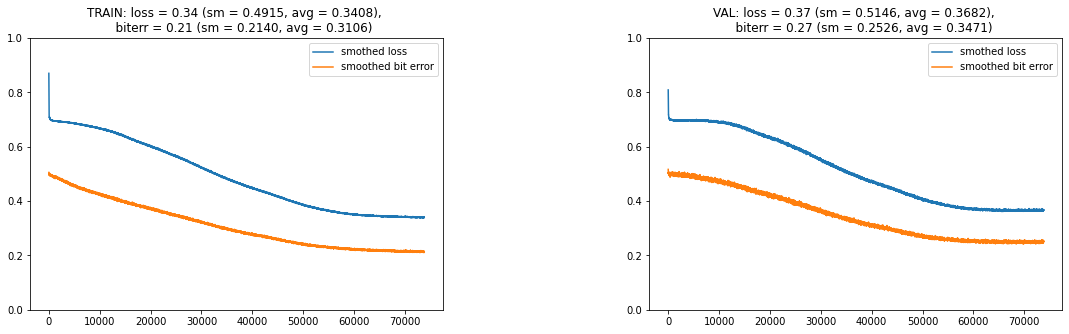

KeyboardInterrupt: ignored

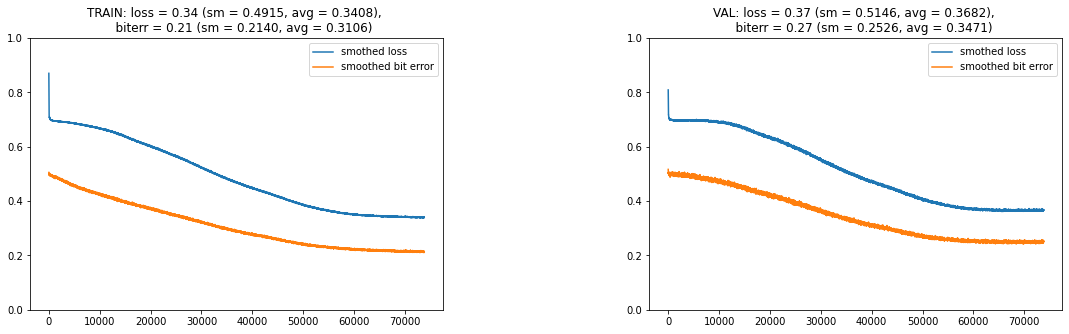

In [ ]:
crypto_net = CryptoNet([128,256,256,128], task=CLASSIFICATION)
crypto_net.initializeWeights()
train(crypto_net, d2, learning_rate=0.0006)

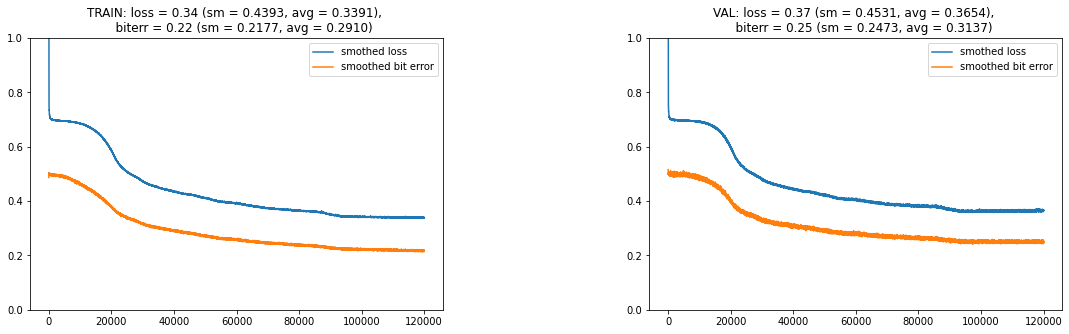

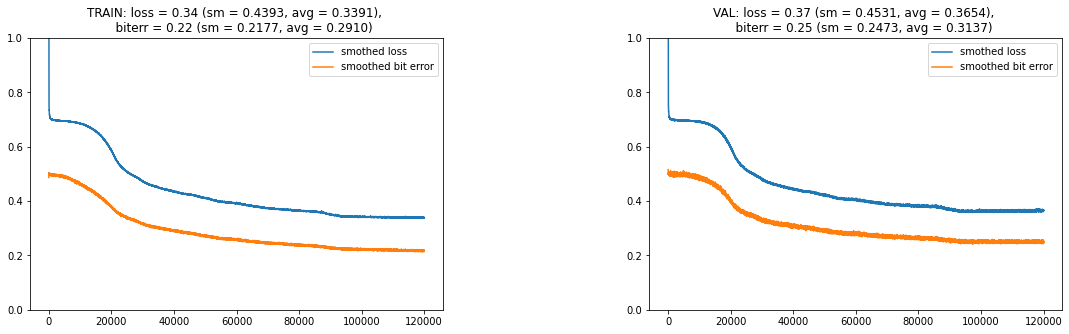

In [ ]:
crypto_net_rnn = cryptoNetRNN(256,512,256,256,2,task=CLASSIFICATION)
crypto_net_rnn.initializeWeights()
crypto_net_rnn = train(crypto_net_rnn, d2, learning_rate=0.0005)

In [ ]:
decryptor_net = DecodeNet(2, CLASSIFICATION)
decryptor_net.initializeWeights()
train(decryptor_net, d2, learning_rate=0.001)

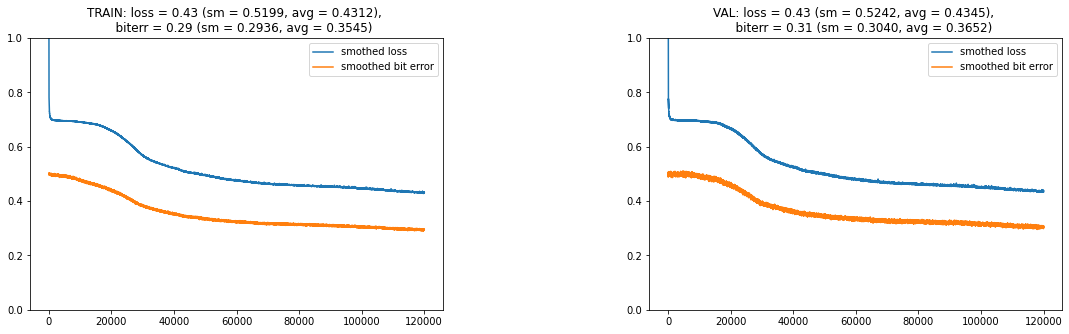

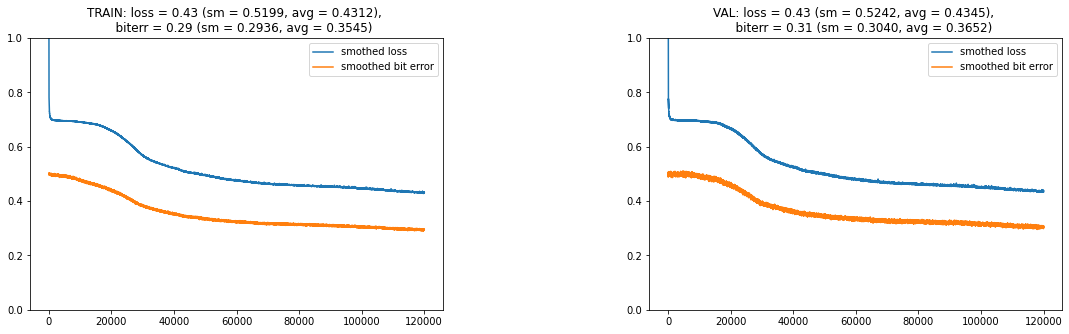

In [ ]:
crypto_net_rnn_base = cryptoNetRNN(128,256,128,0,2,task=CLASSIFICATION)
crypto_net_rnn_base.initializeWeights()
crypto_net_rnn_base = train(crypto_net_rnn_base, d2, learning_rate=0.0005)

# Evaluation

In [ ]:
def test(net,data):
  test_ciphertext_tensor = data['test']['ciphertext'].float()
  test_plaintext_tensor = data['test']['plaintext'].long()

  if net.task == CLASSIFICATION:
    loss_fn = nn.CrossEntropyLoss()

    def compute_loss(preds, targets):
      return loss_fn(preds, targets)

    def bit_err(preds, targets):
      plaintext_guesses = plaintext_preds.argmax(dim = 1)
      return torch.mean(torch.abs(plaintext_guesses - plaintext_targets).float())
  elif net.task == REGRESSION:
    loss_fn = nn.MSELoss()

    def compute_loss(preds, targets):
      return loss_fn(preds, targets.float())

    def bit_err(preds, targets):
      plaintext_guesses = plaintext_preds.round()
      return torch.mean(torch.abs(plaintext_guesses - plaintext_targets).float())
  else:
    raise ValueError('net task must be REGRESSION or CLASSIFICATION')

  losses_test = []
  biterr_test = []
  for i in range(500):
    batch_indices = np.random.choice(SAMPLES['test'], BATCH_SIZE//4)
    plaintext_targets = test_plaintext_tensor[batch_indices, :]
    ciphertext_examples = test_ciphertext_tensor[batch_indices, :]
    plaintext_preds = net(ciphertext_examples)

    loss = compute_loss(plaintext_preds, plaintext_targets)
    biterr = bit_err(plaintext_preds, plaintext_targets)

    losses_test.append(loss.detach().numpy())
    biterr_test.append(biterr.detach().numpy())
  print('Test BER of model:')
  print(np.mean(biterr_test))


In [ ]:
test(crypto_net_rnn,d2)

Test BER of model:
0.2507207


In [ ]:
test(crypto_net,d2)

Test BER of model:
0.2487832


In [ ]:
test(crypto_net_rnn_base,d2)

Test BER of model:
0.3059336
